<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/S%26P_500_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:29:33 Starting...
14:29:33 Installing yfinance into Google notebook...
14:29:40 Installing arch into Google notebook...
14:29:50 Initialized.


In [2]:
display(sp500:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0])

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [3]:
results=pd.DataFrame({"Sample":list(range(N:=10))}).set_index("Sample")

for i in results.index:
    df=download(list(sp500.sample(2,axis=0)['Symbol'])).dropna()

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')

    for j in range(2):
        results.loc[i,j]=tickers[j]

    results.loc[i,"Correlation"]=df.corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index([0,1],inplace=True)
results.index.names=["Ticker 1","Ticker 2"]
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=results["Correlation"].mean()
display(results)

[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[***

,,Correlation,Sample
Ticker 1,Ticker 2,,
REGN,MTB,84.021350,8416.0
REG,PEP,89.622653,7762.0
MDT,IRM,76.033411,7192.0
ZBRA,MO,75.593826,8321.0
DVN,SNA,47.254863,9855.0
MAR,VZ,83.116445,6653.0
WBA,COST,41.468087,9612.0
EIX,PPG,95.258174,11207.0
POOL,CMG,88.899628,4678.0


  0%|          | 0/10 [00:00<?, ?it/s]

[*********************100%***********************]  150 of 150 completed
[*********************100%***********************]  318 of 318 completed
[*********************100%***********************]  385 of 385 completed
[*********************100%***********************]  257 of 257 completed
[*********************100%***********************]  43 of 43 completed
[*********************100%***********************]  160 of 160 completed
[*********************100%***********************]  446 of 446 completed
[*********************100%***********************]  214 of 214 completed
[*********************100%***********************]  398 of 398 completed
[*********************100%***********************]  453 of 453 completed


,Assets,Portfolio,Independent
Sample,,,
1,150.0,0.936297,0.028543
2,318.0,0.880746,0.012639
3,385.0,0.928707,0.011879
4,257.0,0.955394,0.016573
5,43.0,1.267827,0.122216
6,160.0,1.128798,0.029524
7,446.0,0.932815,0.010185
8,214.0,1.018971,0.022707
9,398.0,0.917704,0.011293


Text(0, 0.5, 'Actual Portfolio Variance (Daily Return Squared)')

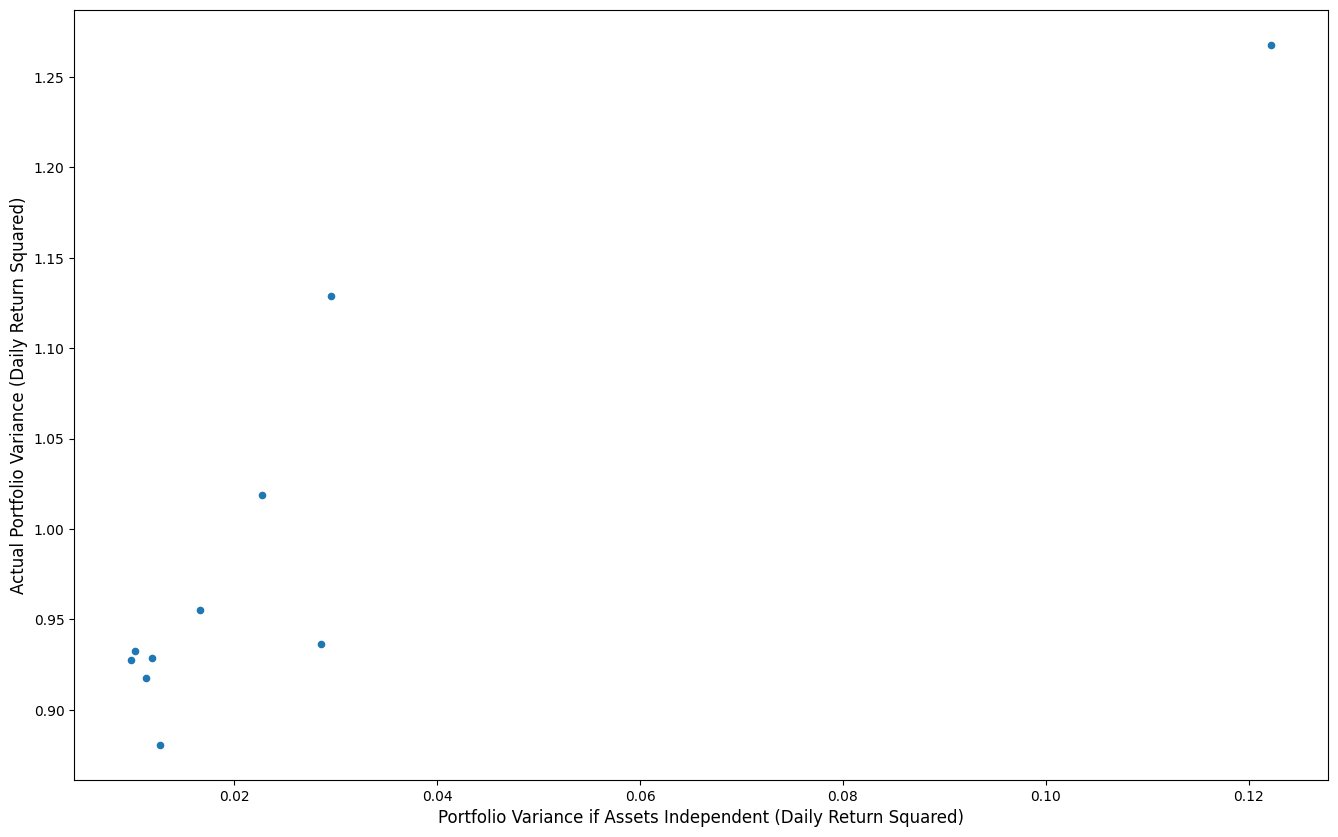

In [67]:
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

first_date=sp500['Date added'].max()
results=pd.DataFrame({"Sample":range(1,(n:=25)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*}).set_index("Sample")

for i in tqdm(results.index):
    closes=pd.DataFrame(download(stocks:=[t for t in sp500.sample(np.random.randint(1,sp500.shape[0]),axis=0)['Symbol'] if '.B' not in t],first_date)['Adj Close']) # wrap w/DataFrame in case Series
    closes.index=pd.DatetimeIndex(closes.index).to_period('B')

    returns=pd.DataFrame()

    for ticker in closes.columns:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred

        if returns[ticker].shape[0]<1: # exclude all NA time-series
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    returns['Portfolio']=returns.mean(axis=1)
    results.loc[i,"Assets"]=returns.shape[1]-1
    results.loc[i,"Portfolio"]=returns['Portfolio'].var()
    results.loc[i,"Independent"]=returns.var().mean()/results.loc[i,"Assets"]

results.dropna(inplace=True)
display(results)

Text(0.5, 1.0, 'Daily Returns Squared, 2024-07-08 to 2024-08-29')

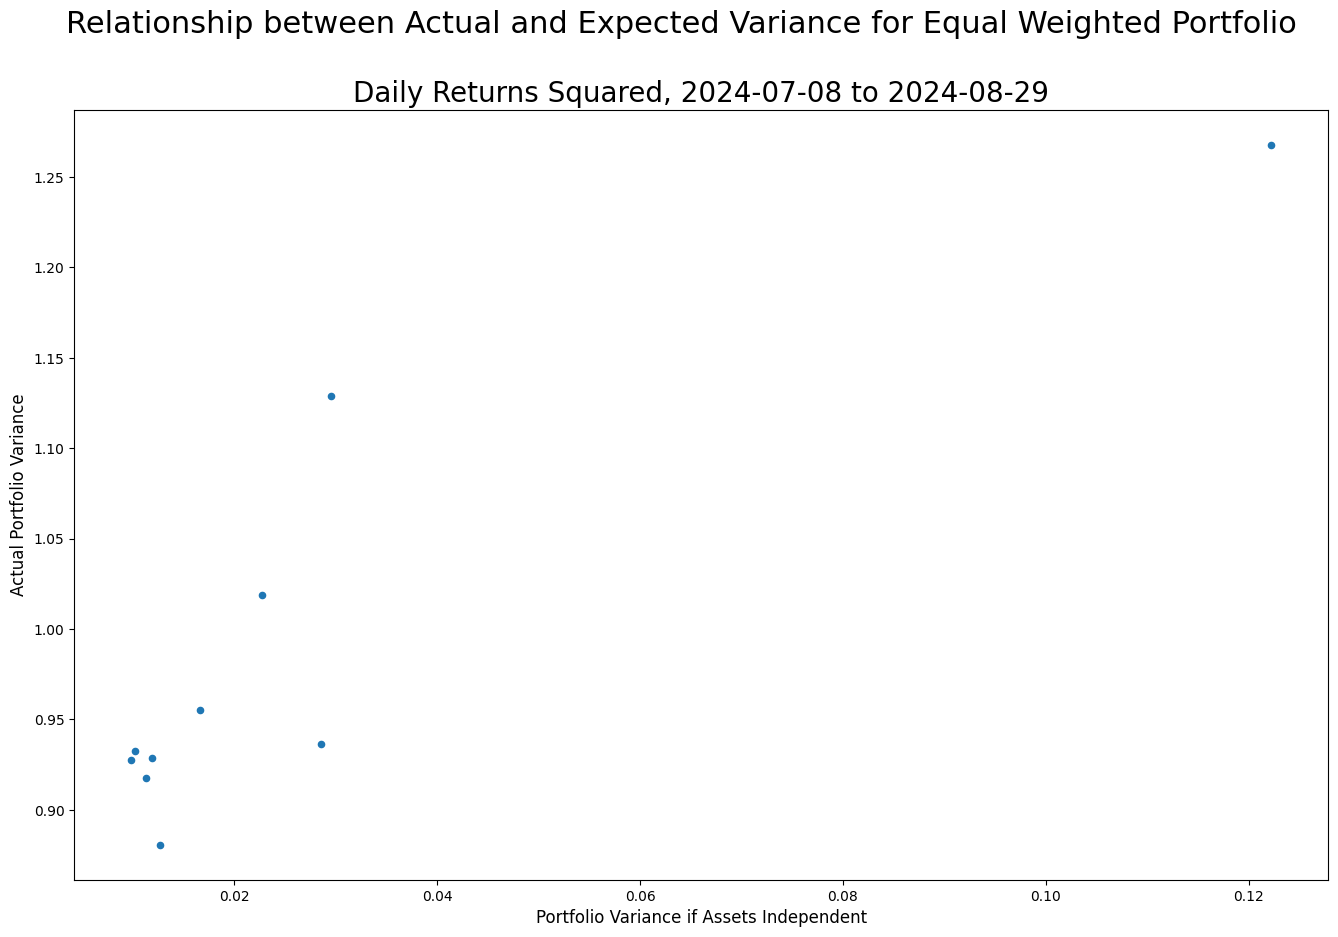

In [70]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
results.plot.scatter(x:="Independent",y:="Portfolio",ax=plot)
plot.set_xlabel("Portfolio Variance if Assets Independent",fontsize=12)
plot.set_ylabel("Actual Portfolio Variance",fontsize=12)
figure.suptitle(title:="Relationship between Actual and Expected Variance for Equal Weighted Portfolio",fontsize=22)
plot.set_title("Daily Returns Squared, %s to %s" % (first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
